##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [2]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


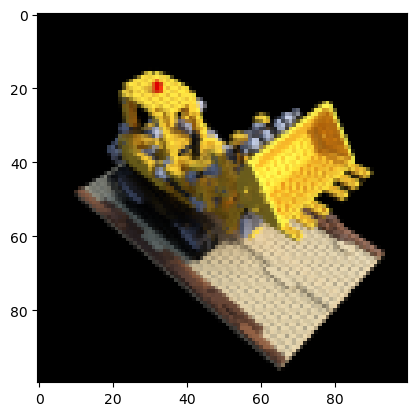

In [4]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [7]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc

In [8]:
def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
model = init_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 39)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  10240     ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 256)                  65792     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 256)                  65792     ['dense_1[0][0]']             
                                                                                              

### Rays

#### Get Rays Origin and Direction

In [10]:
def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

**Example**

In [11]:
rays_o, rays_d = get_rays(H, W, focal, testpose)
print(len(rays_o))
print(len(rays_o[0]))
print(len(rays_o[0][0]))

100
100
3


#### Render the Rays

In [12]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

**Example**

In [13]:
rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, rand=True)

print("RGB")
print(len(rgb))
print(rgb[0][0:10])
print("DEPTH")
print(len(depth))
print(depth[0][0:10])
print("ACC")
print(len(acc))
print(acc[0][0:10])

RGB
100
tf.Tensor(
[[0.45126712 0.54381967 0.5254133 ]
 [0.4568286  0.5469775  0.51736194]
 [0.45641938 0.5432206  0.50508094]
 [0.451432   0.55764645 0.5133712 ]
 [0.4513271  0.5722662  0.5144571 ]
 [0.4541291  0.57612205 0.5067898 ]
 [0.46026284 0.5700741  0.48890755]
 [0.45596993 0.55517864 0.47119266]
 [0.44958013 0.5613327  0.4698284 ]
 [0.46108413 0.5739262  0.47485593]], shape=(10, 3), dtype=float32)
DEPTH
100
tf.Tensor(
[5.5607862 5.5990553 5.6043186 5.5244904 5.535938  5.51886   5.5000815
 5.444947  5.4587774 5.4460335], shape=(10,), dtype=float32)
ACC
100
tf.Tensor(
[0.99999994 1.0000001  1.0000001  0.9999999  1.0000001  1.0000001
 1.         1.0000002  1.0000001  1.        ], shape=(10,), dtype=float32)


Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.<p>
**PSNR = 10 * log10((MAX^2) / MSE)**

0 1.2356623554229735 secs per iter


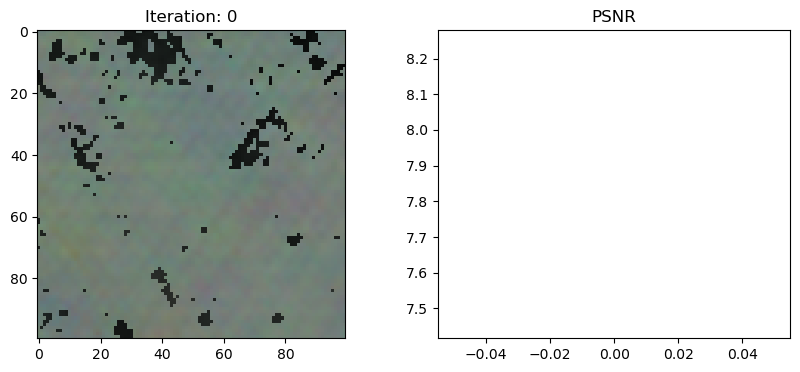

25 16.430459794998168 secs per iter


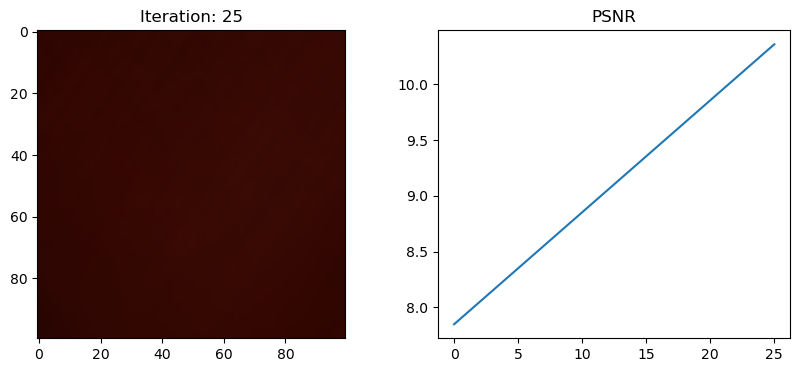

50 10.742878065109252 secs per iter


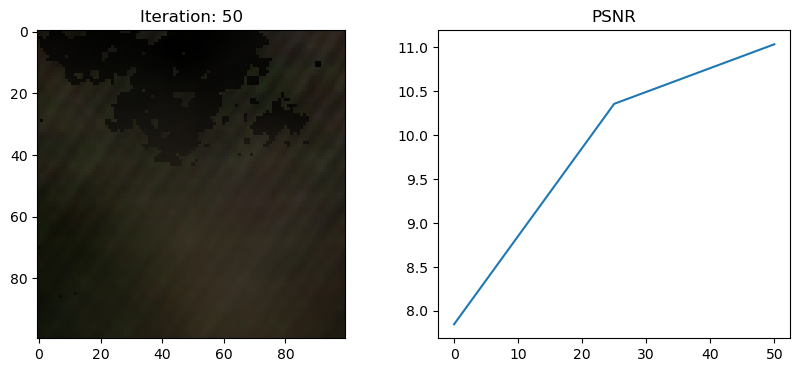

75 37.26330703735351 secs per iter


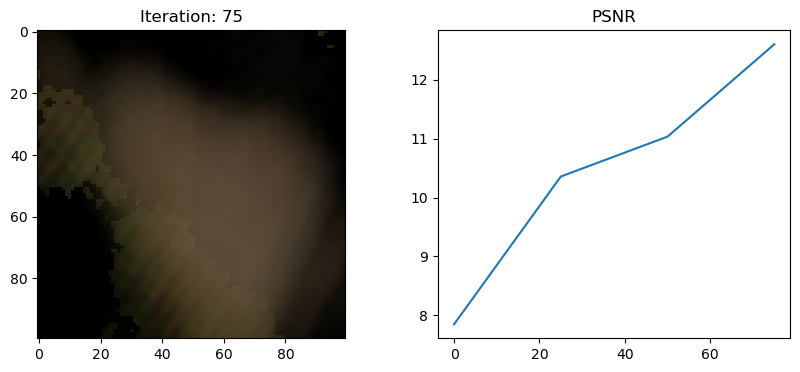

100 33.32403990745544 secs per iter


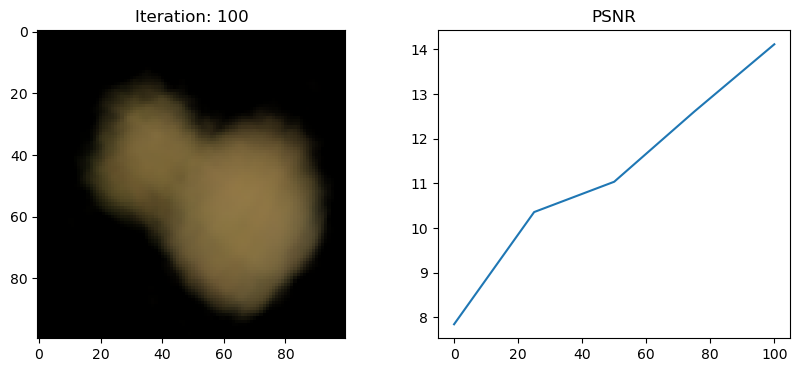

125 1985.5802297782898 secs per iter


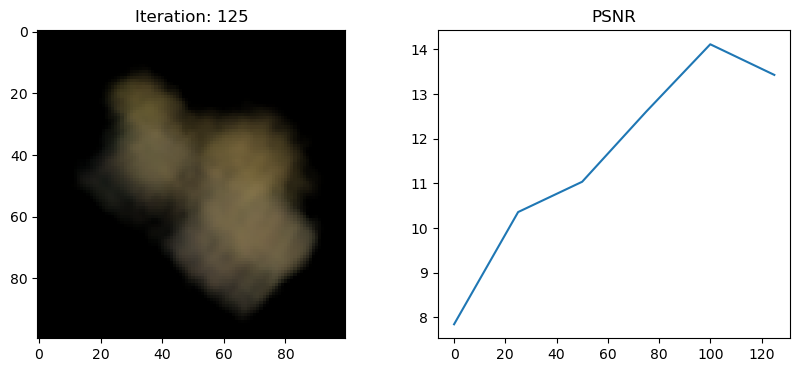

150 10.432436246871948 secs per iter


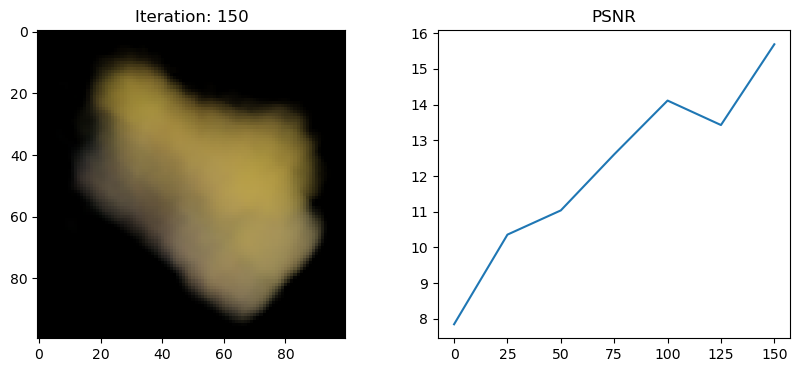

175 11.1812757396698 secs per iter


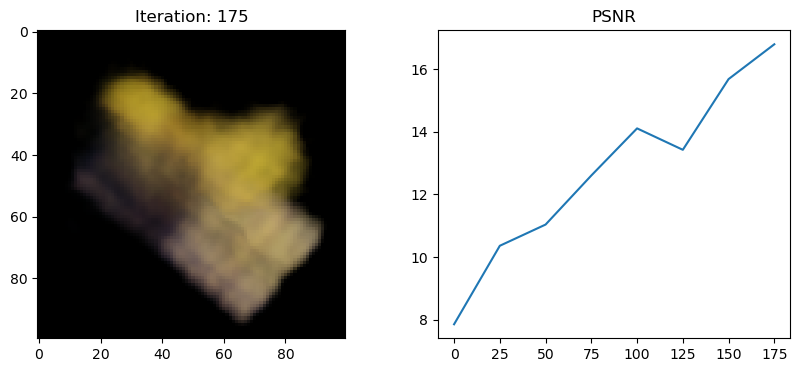

200 10.582479848861695 secs per iter


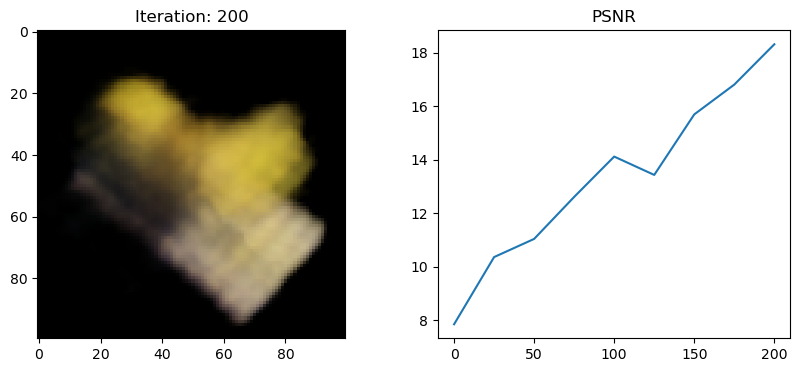

225 12.72651689529419 secs per iter


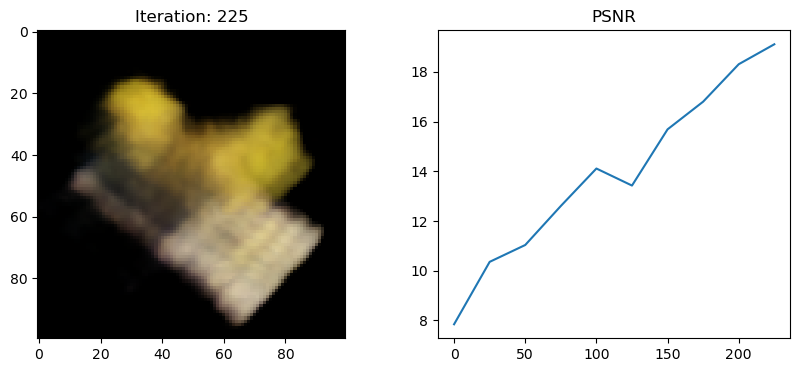

250 15.598428630828858 secs per iter


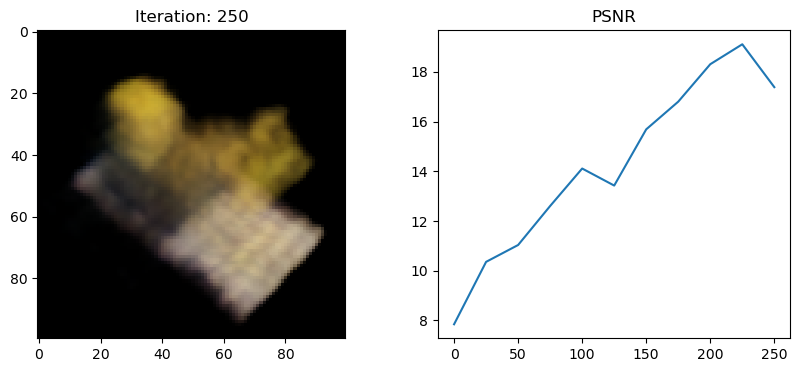

275 13.572457075119019 secs per iter


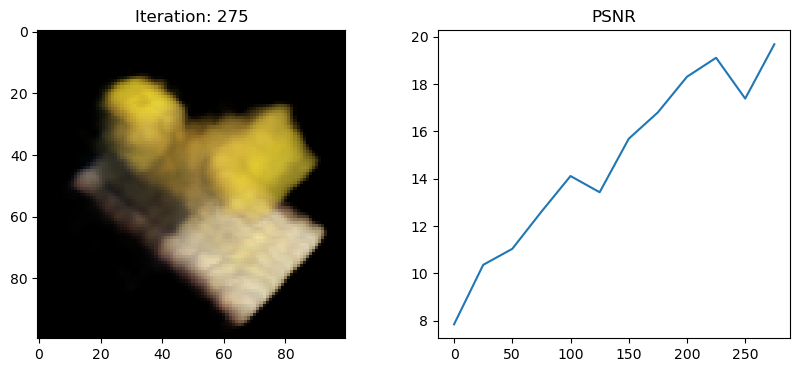

300 11.148101272583007 secs per iter


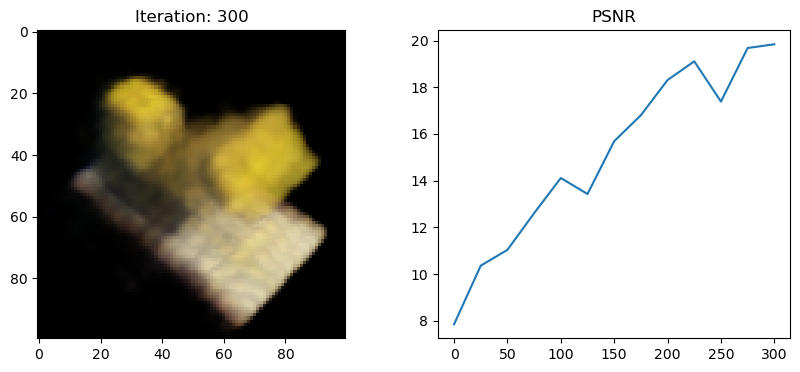

325 10.787935285568237 secs per iter


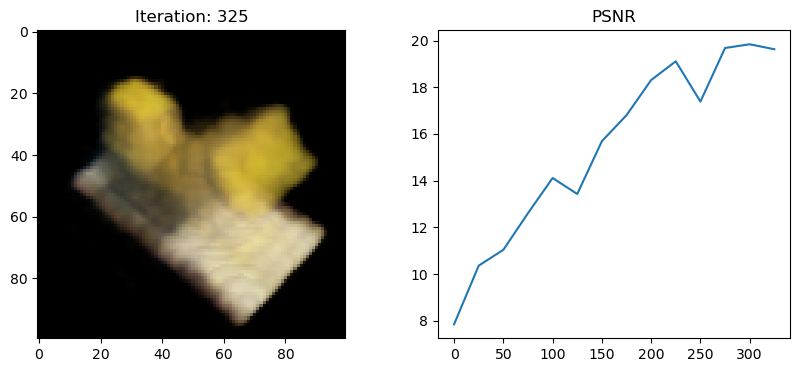

350 12.180117263793946 secs per iter


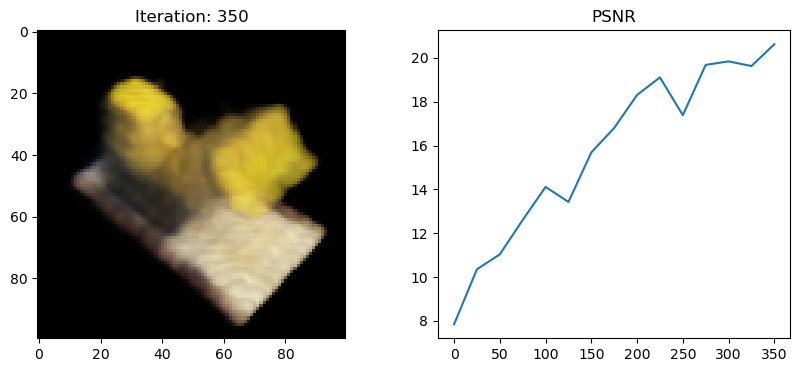

375 12.218535928726196 secs per iter


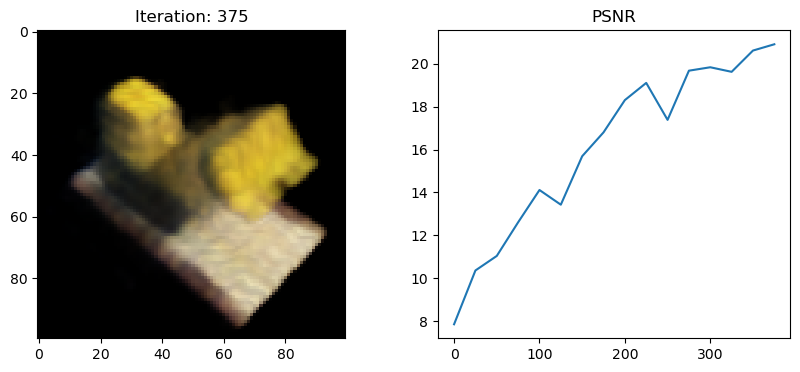

400 12.802957372665405 secs per iter


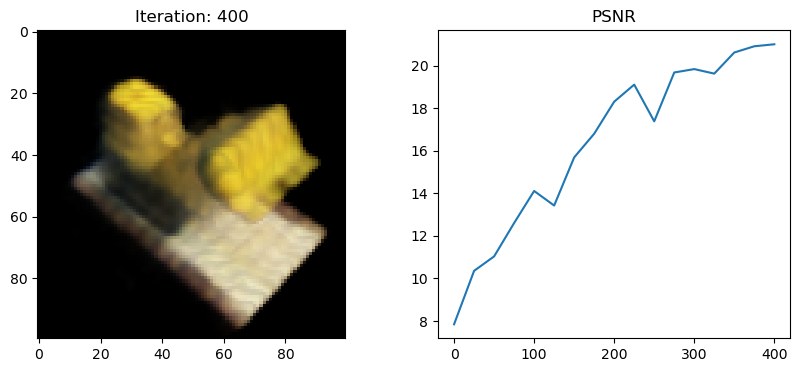

425 11.964133396148682 secs per iter


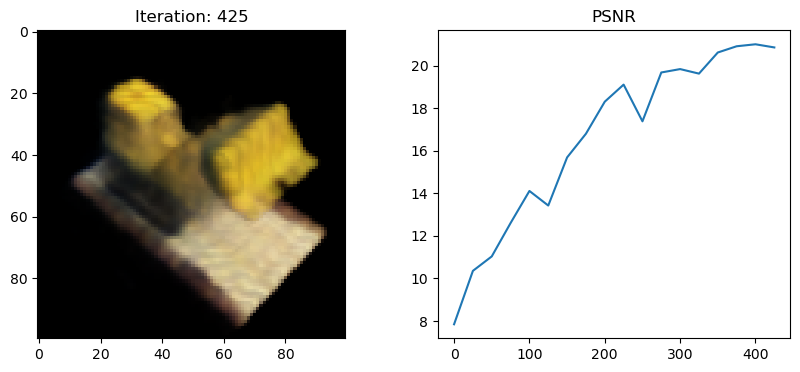

450 11.9792276096344 secs per iter


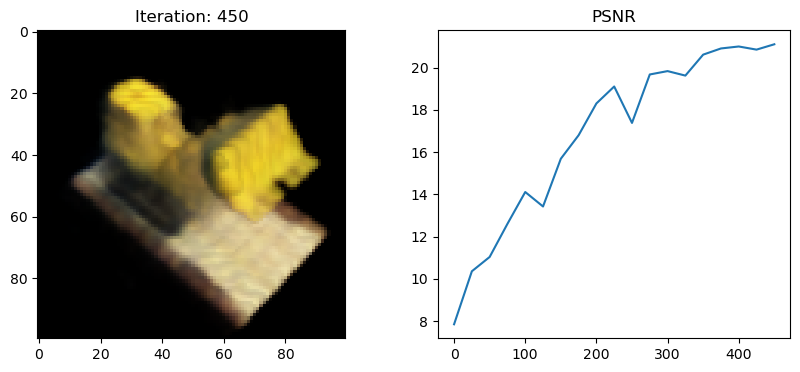

475 10.784082727432251 secs per iter


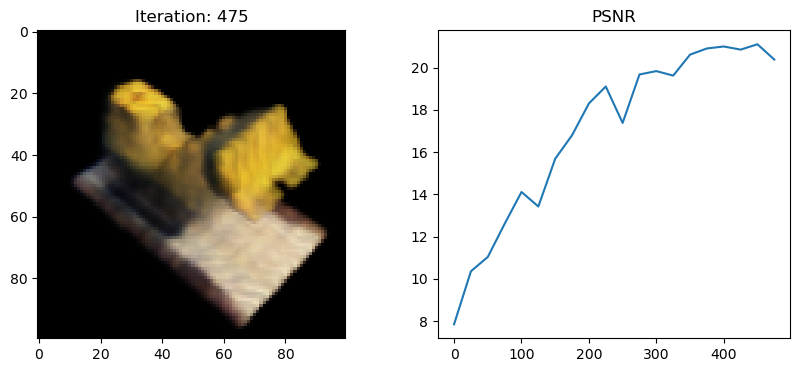

500 10.858456373214722 secs per iter


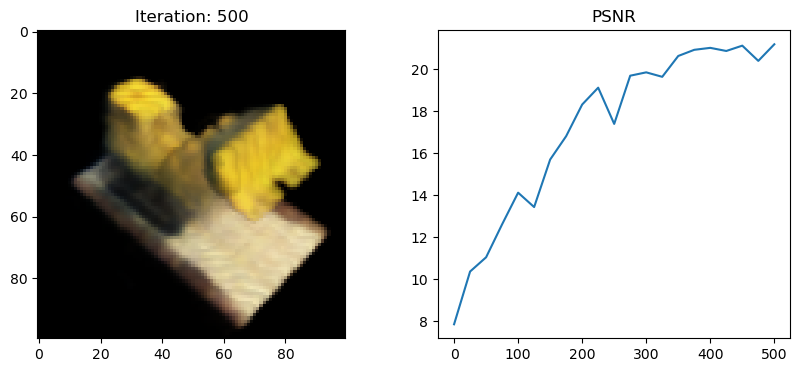

525 10.659564199447631 secs per iter


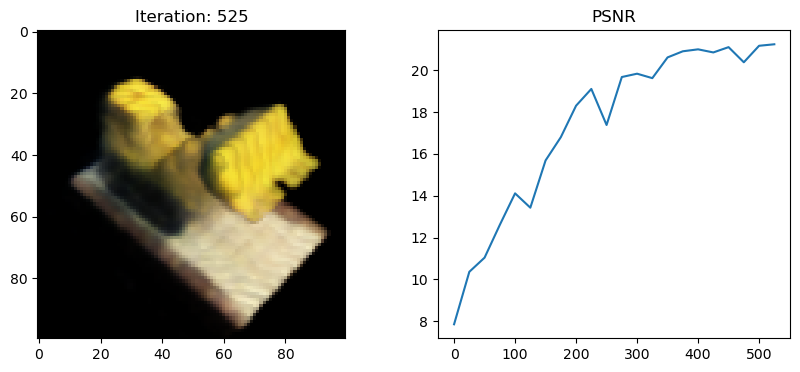

550 10.6833109664917 secs per iter


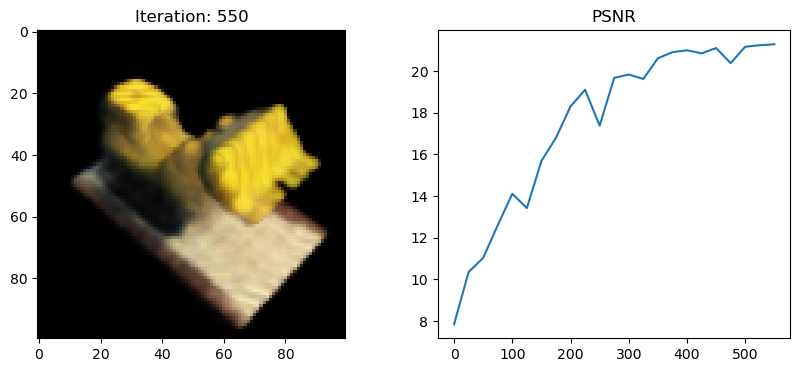

575 10.508194427490235 secs per iter


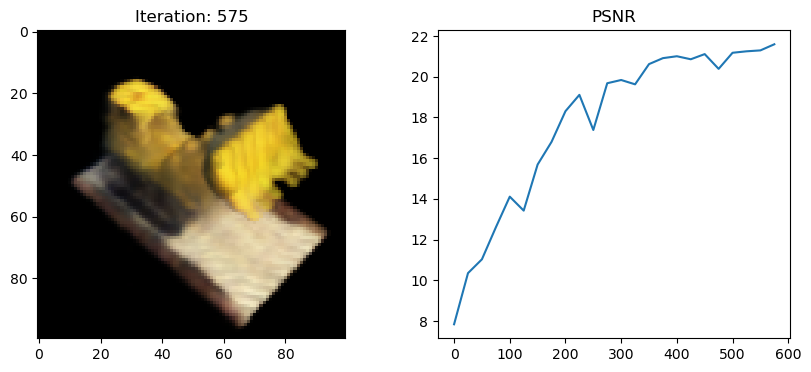

600 10.452286138534546 secs per iter


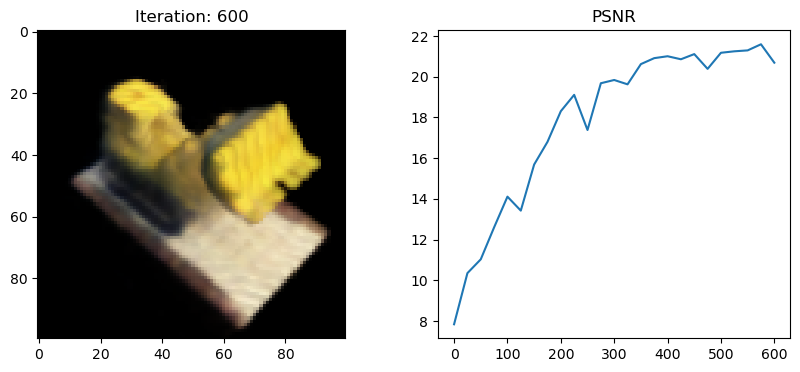

625 10.497038497924805 secs per iter


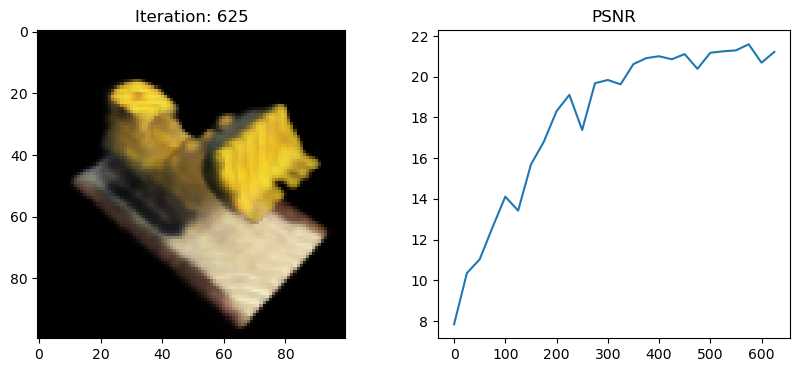

650 10.51002339363098 secs per iter


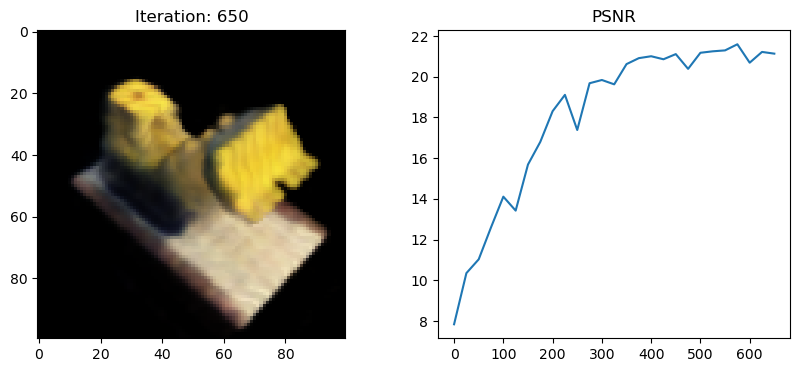

675 10.479151277542114 secs per iter


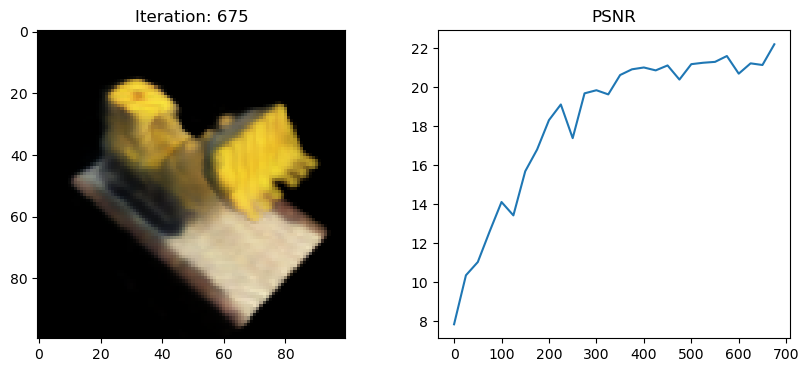

700 10.468235359191894 secs per iter


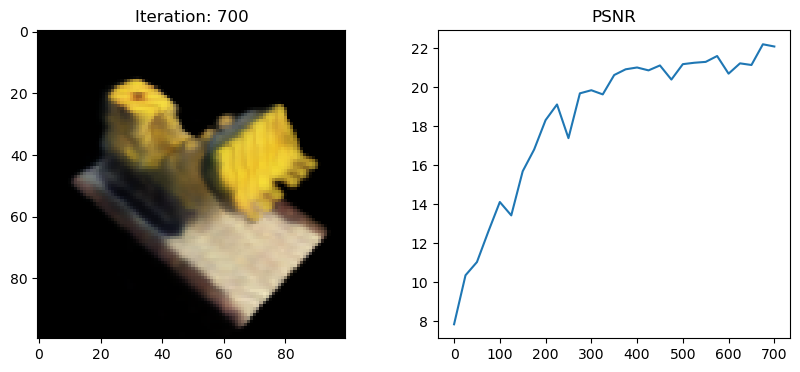

725 10.400240278244018 secs per iter


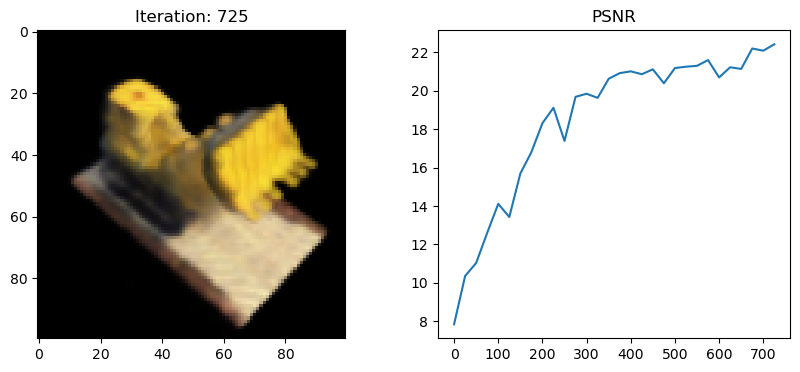

750 10.490455932617188 secs per iter


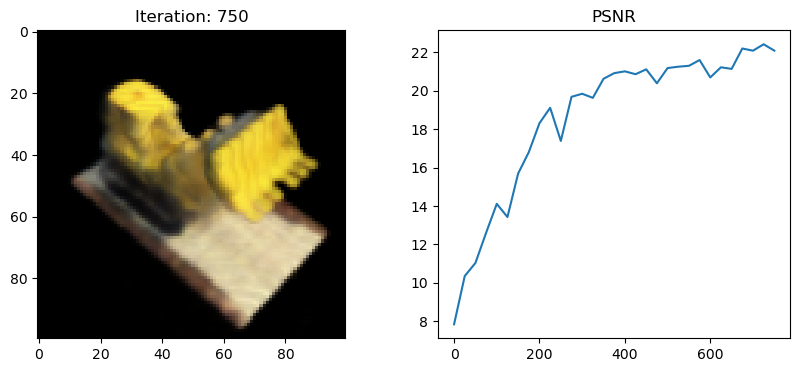

775 10.572764377593995 secs per iter


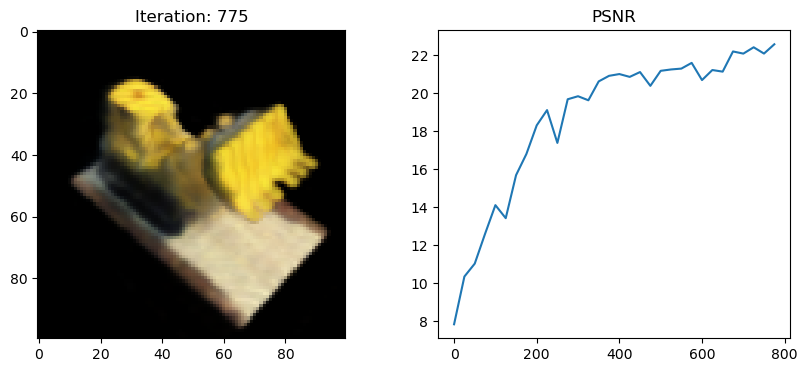

800 10.561228055953979 secs per iter


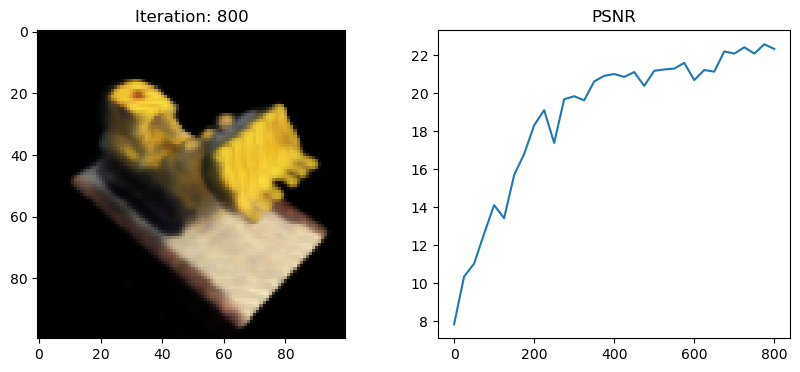

825 14.777141437530517 secs per iter


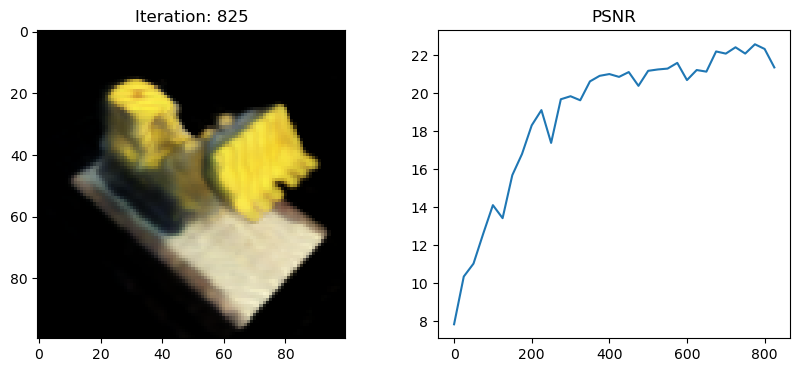

850 18.074388275146486 secs per iter


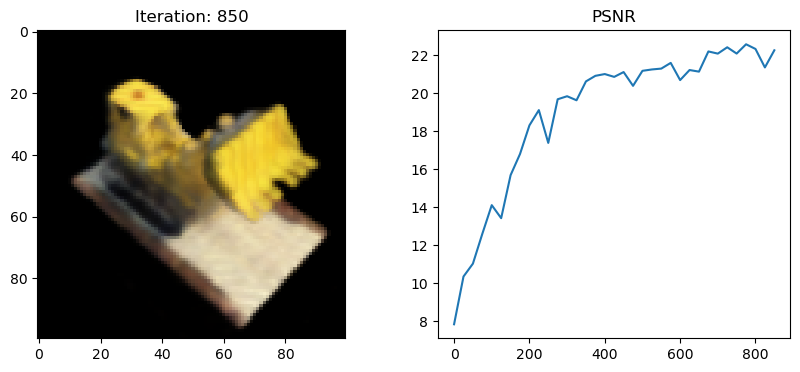

875 197.44050026893615 secs per iter


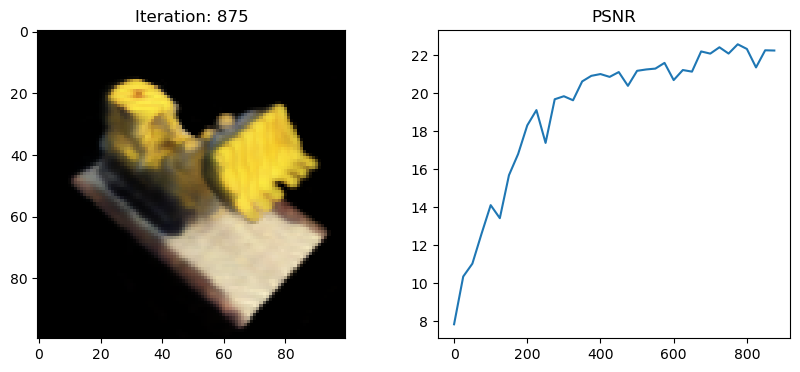

900 13.310215139389038 secs per iter


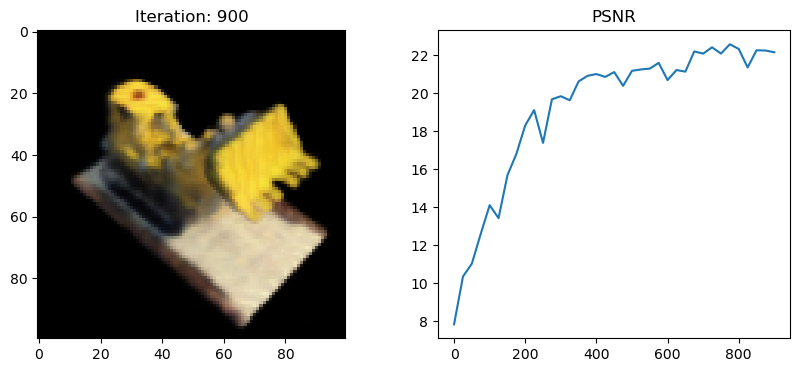

925 12.278716020584106 secs per iter


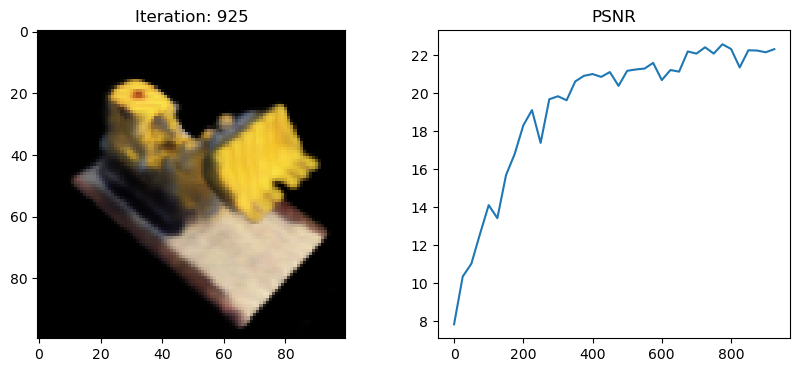

950 12.603557653427124 secs per iter


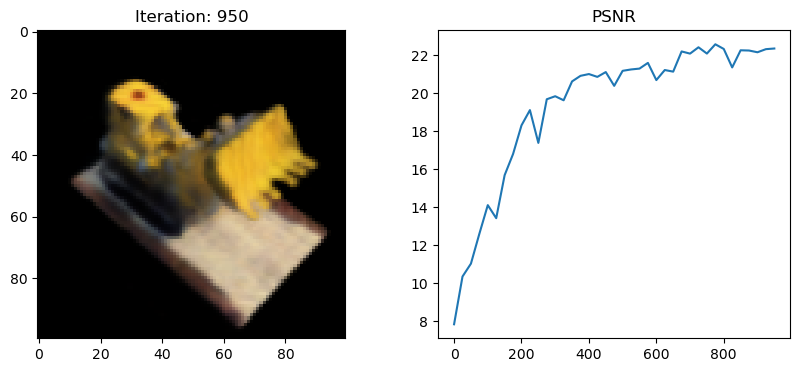

975 12.508901414871216 secs per iter


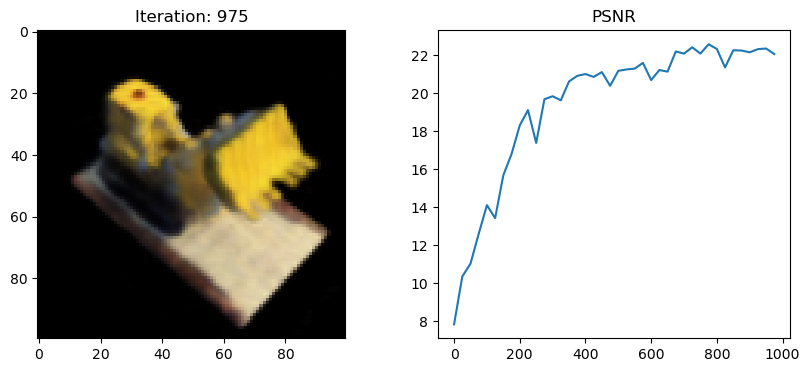

1000 12.356355714797974 secs per iter


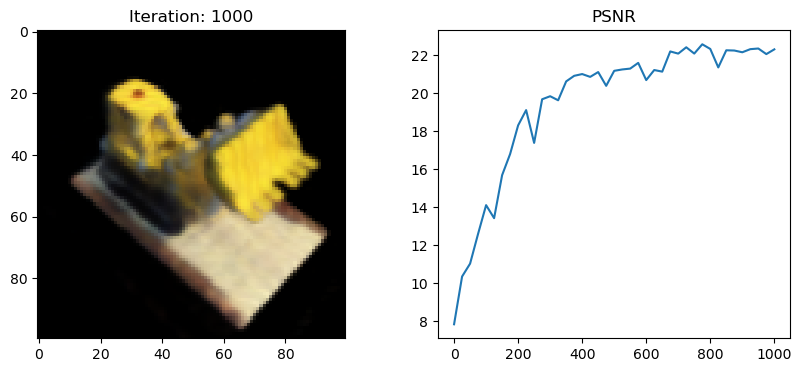

1025 12.282391633987427 secs per iter


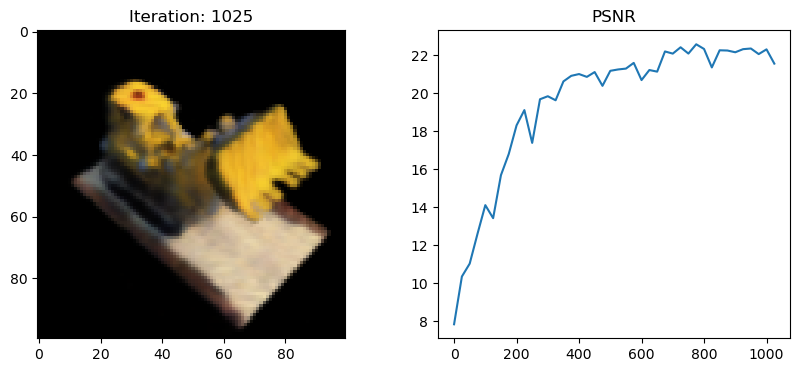

1050 11.707941389083862 secs per iter


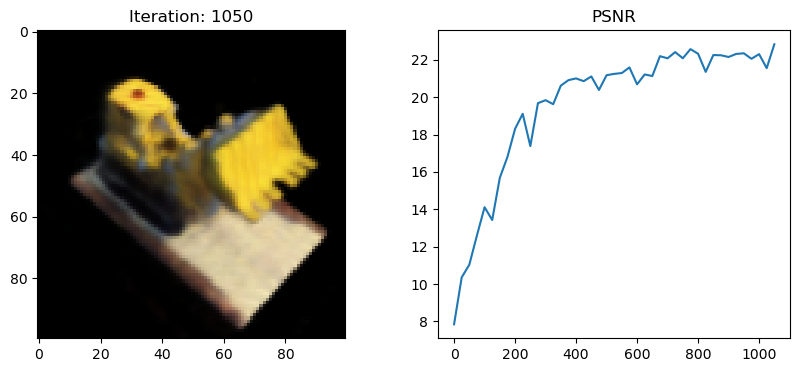

1075 12.242421960830688 secs per iter


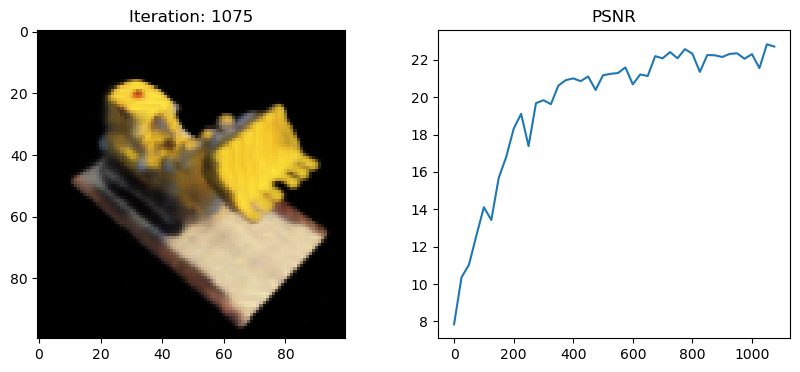

1100 11.193899431228637 secs per iter


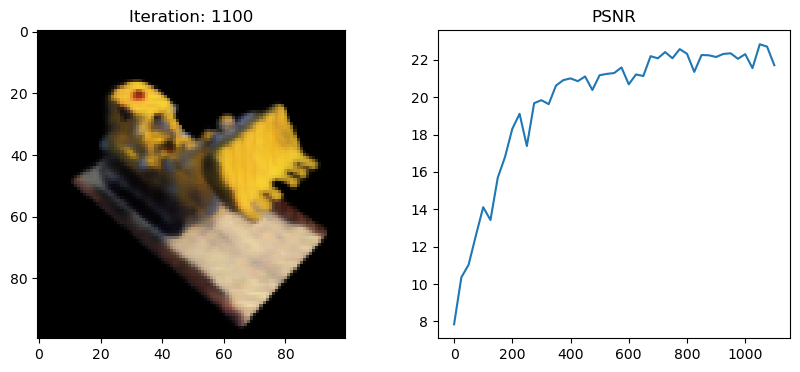

1125 11.229888486862183 secs per iter


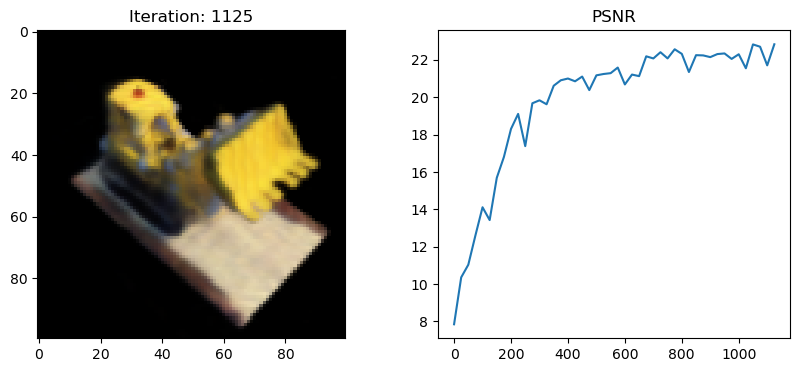

1150 11.226011905670166 secs per iter


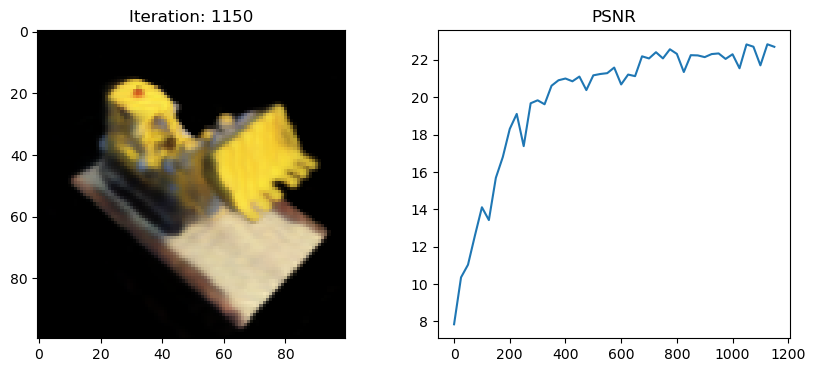

1175 10.516343231201171 secs per iter


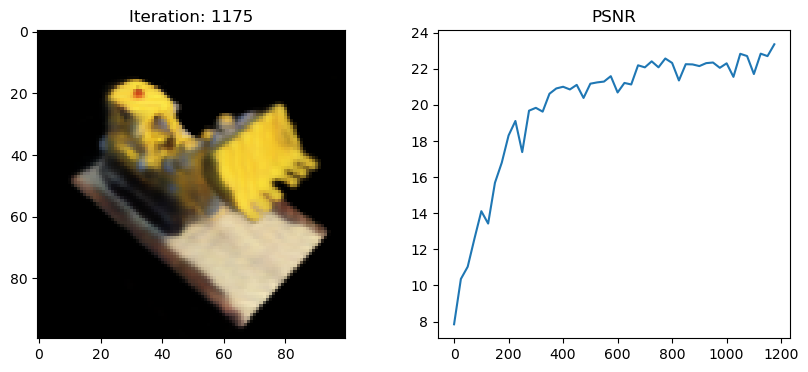

1200 12.90240797996521 secs per iter


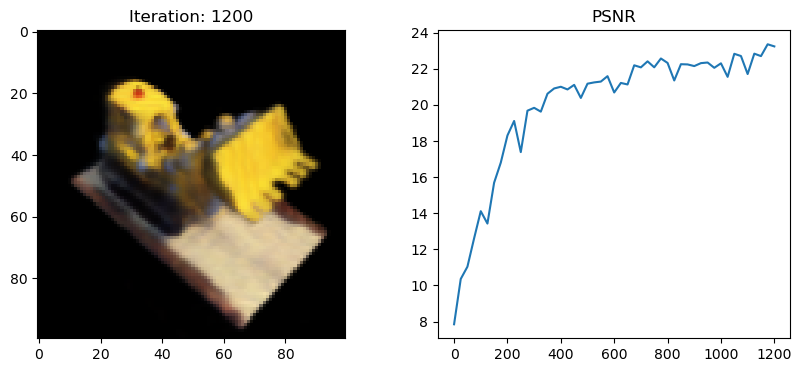

1225 13.44404483795166 secs per iter


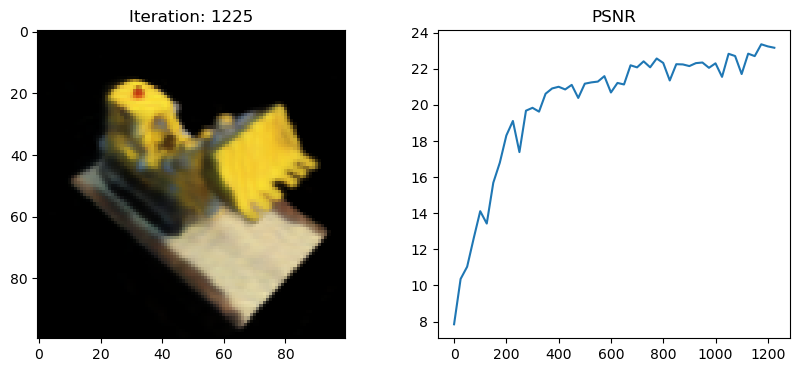

1250 15.489156923294068 secs per iter


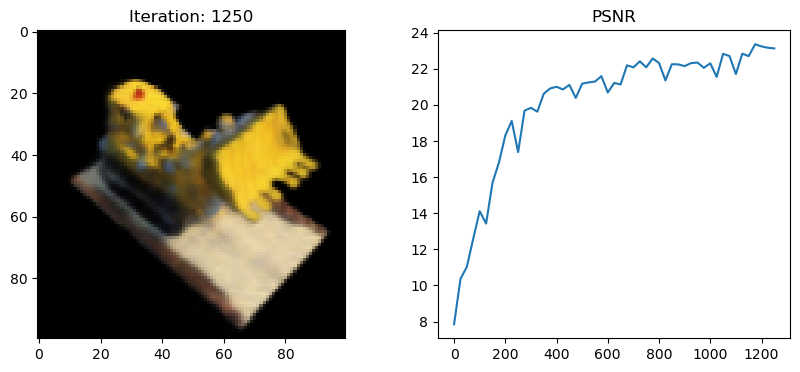

1275 12.637302923202515 secs per iter


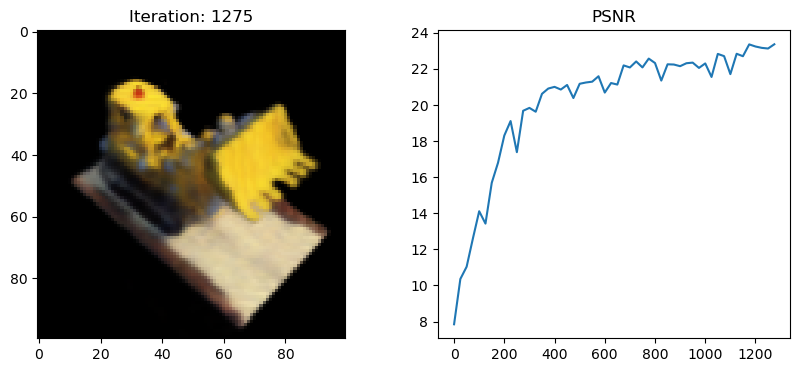

1300 13.834816818237305 secs per iter


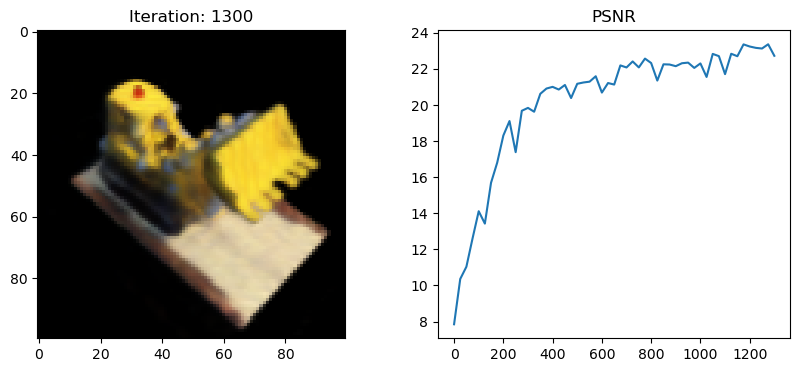

1325 13.05518533706665 secs per iter


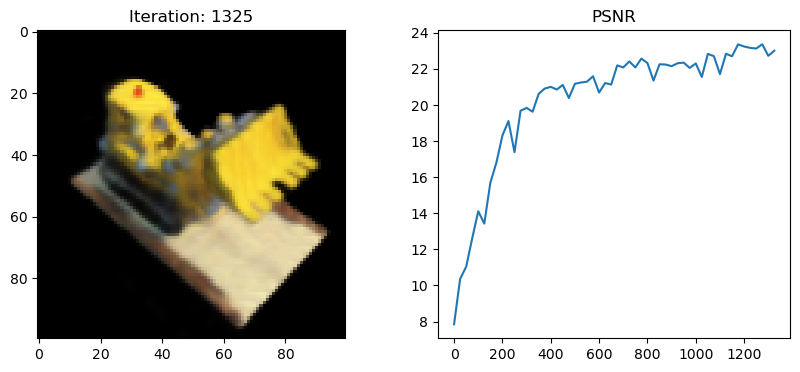

1350 10.964711656570435 secs per iter


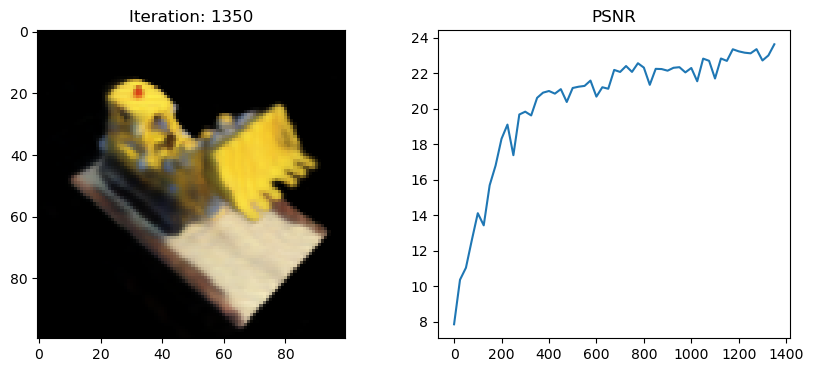

1375 10.644603633880616 secs per iter


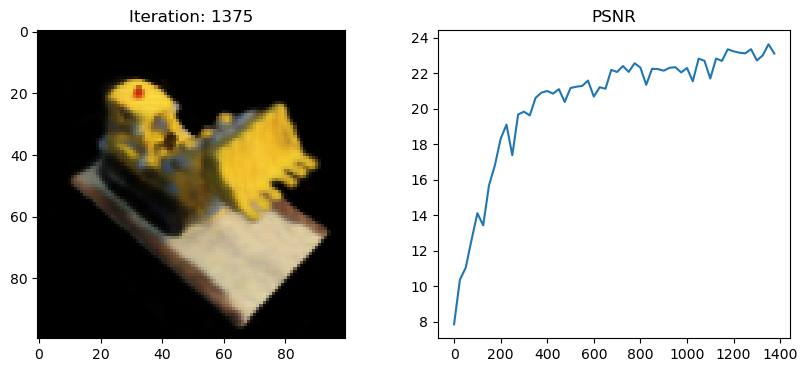

1400 10.688873453140259 secs per iter


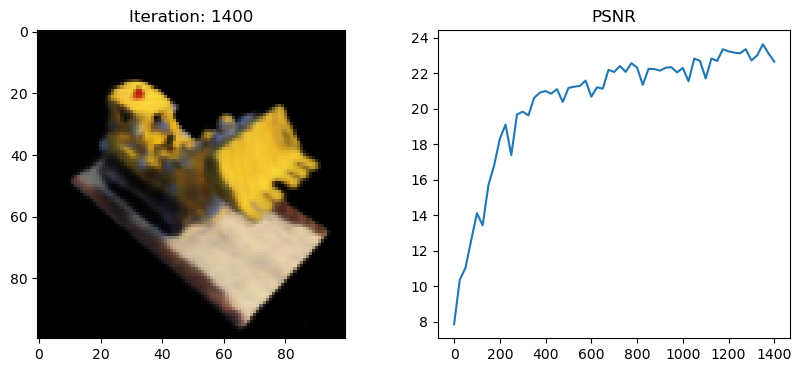

1425 10.727632656097413 secs per iter


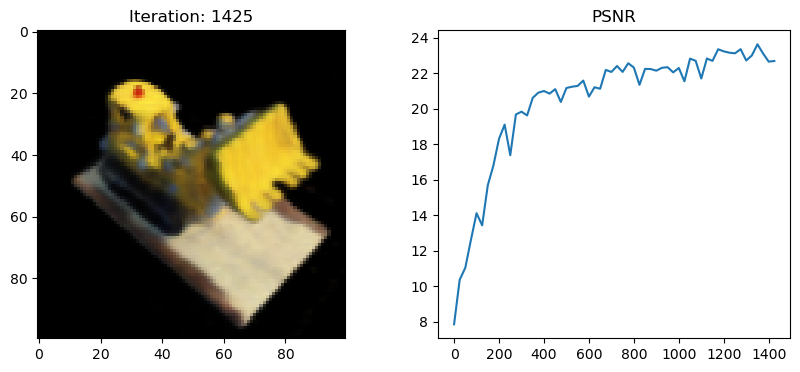

1450 10.737470273971558 secs per iter


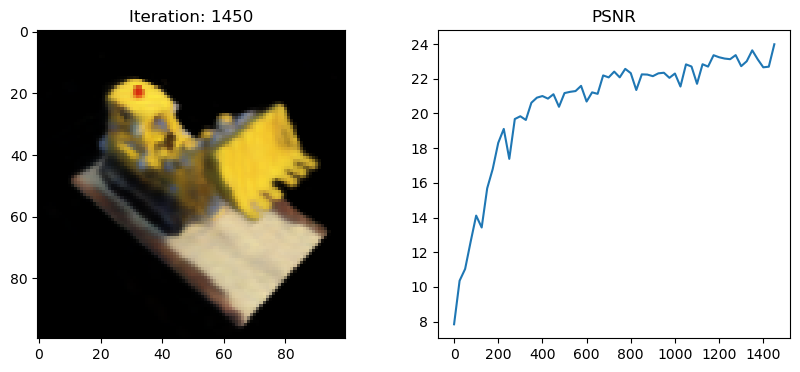

1475 10.762922954559325 secs per iter


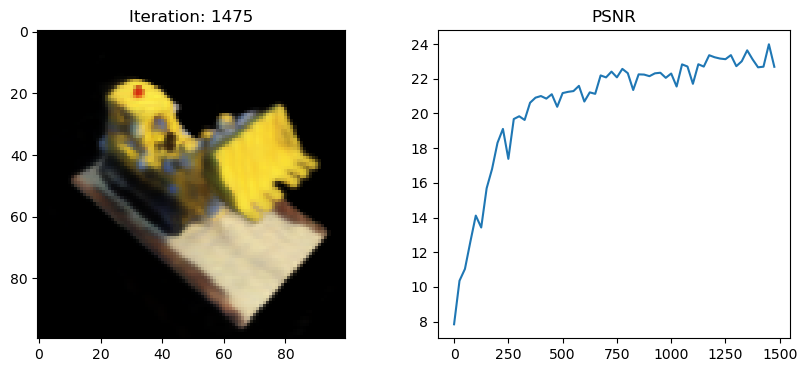

1500 10.787717189788818 secs per iter


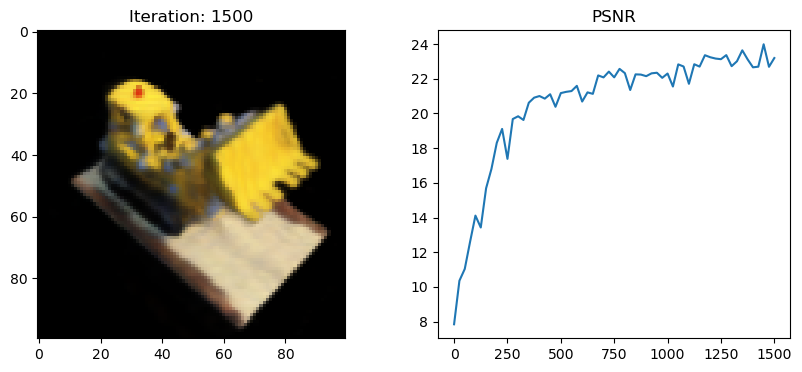

Done


In [14]:
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1500
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [15]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [16]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

C:\Users\mayur\AppData\Local\Temp\ipykernel_28860\3499152080.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [17]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)